Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.3147 - val_loss: 0.4415
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3446 - val_loss: 0.4393
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3098 - val_loss: 0.4393
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3177 - val_loss: 0.4399
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2734 - val_loss: 0.4397
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2923 - val_loss: 0.4402
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3093 - val_loss: 0.4414
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3540 - val_loss: 0.4424
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2901 - val_loss: 0.4434
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3127 - val_loss: 0.4394
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3190 - val_loss: 0.4365
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3751 - val_loss: 0.4402
E

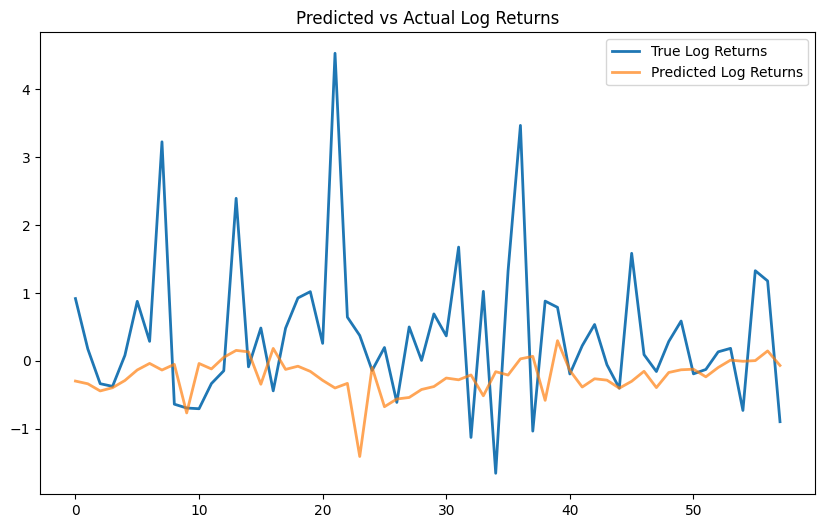

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Load and Preprocess Data
def load_data(file_path, years=10):
    df = pd.read_csv(file_path)
    df = df.iloc[-years * 252:]  # Limit data to most recent 'years'
    df = df[df['close'] > 0]  # Ensure valid prices
    log_returns = np.log(df['close']).diff().dropna()
    # Standardize
    scaler = StandardScaler()
    log_returns = scaler.fit_transform(log_returns.values.reshape(-1, 1)).flatten()
    return log_returns, scaler

# 2. Create Multi-Scale Sequences
def create_sequences(data, short_w, mid_w, long_w):
    X_short, X_mid, X_long, Y = [], [], [], []
    for i in range(long_w, len(data) - 1):
        X_short.append(data[i - short_w:i].reshape(-1, 1))
        X_mid.append(data[i - mid_w:i].reshape(-1, 1))
        X_long.append(data[i - long_w:i].reshape(-1, 1))
        Y.append(data[i + 1])  # Next day's return
    return np.array(X_short), np.array(X_mid), np.array(X_long), np.array(Y)

# 3. Build the Multi-Scale LSTM Model
def build_model(input_shapes, hidden_size=64):
    # Define inputs
    input_short = Input(shape=input_shapes[0], name="short_input")
    input_mid = Input(shape=input_shapes[1], name="mid_input")
    input_long = Input(shape=input_shapes[2], name="long_input")

    # LSTM layers
    short_out = LSTM(hidden_size, name="short_lstm")(input_short)
    mid_out = LSTM(hidden_size, name="mid_lstm")(input_mid)
    long_out = LSTM(hidden_size, name="long_lstm")(input_long)

    # Combine outputs
    combined = Concatenate()([short_out, mid_out, long_out])
    output = Dense(1, activation='linear', name="output_layer")(combined)

    # Build and compile model
    model = Model(inputs=[input_short, input_mid, input_long], outputs=output)

    from tensorflow.keras.losses import Huber

    model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber())
    return model

# 4. Train and Evaluate the Model
def train_and_evaluate(X_short, X_mid, X_long, Y):
    # Split into train, validation, and test
    X_train_s, X_temp_s, Y_train, Y_temp = train_test_split(X_short, Y, test_size=0.3, shuffle=False)
    X_val_s, X_test_s, Y_val, Y_test = train_test_split(X_temp_s, Y_temp, test_size=0.5, shuffle=False)

    X_train_m, X_temp_m = train_test_split(X_mid, test_size=0.3, shuffle=False)
    X_val_m, X_test_m = train_test_split(X_temp_m, test_size=0.5, shuffle=False)

    X_train_l, X_temp_l = train_test_split(X_long, test_size=0.3, shuffle=False)
    X_val_l, X_test_l = train_test_split(X_temp_l, test_size=0.5, shuffle=False)

    # Build model
    model = build_model([(X_short.shape[1], 1), (X_mid.shape[1], 1), (X_long.shape[1], 1)])

    # Train model
    history = model.fit(
        [X_train_s, X_train_m, X_train_l], Y_train,
        validation_data=([X_val_s, X_val_m, X_val_l], Y_val),
        epochs=50, batch_size=32, verbose=1
    )

    # Evaluate on test set
    test_loss = model.evaluate([X_test_s, X_test_m, X_test_l], Y_test)
    print(f"Test Loss: {test_loss:.4f}")

    # Predictions
    predictions = model.predict([X_test_s, X_test_m, X_test_l])

    return model, history, predictions, Y_test

# 5. Main Execution
if __name__ == "__main__":
    # Parameters
    file_path = "cache/UAL_max_1day_data.csv"  # Replace with your file path
    short_window, mid_window, long_window = 5, 15, 120

    # Load data
    log_returns, scaler = load_data(file_path)

    # Create sequences
    X_short, X_mid, X_long, Y = create_sequences(log_returns, short_window, mid_window, long_window)

    # Train and evaluate
    model, history, predictions, Y_test = train_and_evaluate(X_short, X_mid, X_long, Y)

    # Plot Predictions vs Actual
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label="True Log Returns", linewidth=2)
    plt.plot(predictions, label="Predicted Log Returns", linewidth=2, alpha=0.7)
    plt.title("Predicted vs Actual Log Returns")
    plt.legend()
    plt.show()

In [7]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
import matplotlib.pyplot as plt

# 1. Load and Preprocess Data
def load_data(file_path, years=2):
    df = pd.read_csv(file_path)
    df = df.iloc[-years * 252:]  # Limit data to most recent 'years'
    df = df[df['close'] > 0]  # Ensure valid prices
    log_returns = np.log(df['close']).diff().dropna()
    # Standardize
    scaler = StandardScaler()
    log_returns = scaler.fit_transform(log_returns.values.reshape(-1, 1)).flatten()
    return log_returns, scaler

# 2. Create Multi-Scale Sequences
def create_sequences(data, short_w, mid_w, long_w):
    X_short, X_mid, X_long, Y = [], [], [], []
    for i in range(long_w, len(data) - 1):
        X_short.append(data[i - short_w:i].reshape(-1, 1))
        X_mid.append(data[i - mid_w:i].reshape(-1, 1))
        X_long.append(data[i - long_w:i].reshape(-1, 1))
        Y.append(data[i + 1])  # Next day's return
    return np.array(X_short), np.array(X_mid), np.array(X_long), np.array(Y)

# 3. Build the Multi-Scale LSTM Model
def build_model(input_shapes, hidden_size, learning_rate):
    input_short = Input(shape=input_shapes[0], name="short_input")
    input_mid = Input(shape=input_shapes[1], name="mid_input")
    input_long = Input(shape=input_shapes[2], name="long_input")

    short_out = LSTM(hidden_size, name="short_lstm")(input_short)
    mid_out = LSTM(hidden_size, name="mid_lstm")(input_mid)
    long_out = LSTM(hidden_size, name="long_lstm")(input_long)

    combined = Concatenate()([short_out, mid_out, long_out])
    output = Dense(1, activation='linear', name="output_layer")(combined)

    model = Model(inputs=[input_short, input_mid, input_long], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=Huber())
    return model

# 4. Grid Search Function
def grid_search(X_short, X_mid, X_long, Y, param_grid):
    results = []
    best_model = None
    best_val_loss = float('inf')

    # Grid Search
    for params in itertools.product(*param_grid.values()):
        hidden_size, learning_rate, short_w, mid_w, long_w, epochs = params
        print(f"Training with: Hidden={hidden_size}, LR={learning_rate}, Windows={short_w, mid_w, long_w}, Epochs={epochs}")

        # Recreate sequences for the current window sizes
        X_short, X_mid, X_long, Y = create_sequences(log_returns, short_w, mid_w, long_w)

        # Split data into train, val, test
        X_train_s, X_temp_s, Y_train, Y_temp = train_test_split(X_short, Y, test_size=0.3, shuffle=False)
        X_val_s, X_test_s, Y_val, Y_test = train_test_split(X_temp_s, Y_temp, test_size=0.5, shuffle=False)

        X_train_m, X_temp_m = train_test_split(X_mid, test_size=0.3, shuffle=False)
        X_val_m, X_test_m = train_test_split(X_temp_m, test_size=0.5, shuffle=False)

        X_train_l, X_temp_l = train_test_split(X_long, test_size=0.3, shuffle=False)
        X_val_l, X_test_l = train_test_split(X_temp_l, test_size=0.5, shuffle=False)

        # Dynamically build the model with correct input shapes
        model = build_model([(short_w, 1), (mid_w, 1), (long_w, 1)], hidden_size, learning_rate)

        # Train model
        history = model.fit(
            [X_train_s, X_train_m, X_train_l], Y_train,
            validation_data=([X_val_s, X_val_m, X_val_l], Y_val),
            epochs=epochs, batch_size=32, verbose=0
        )

        # Evaluate on validation set
        val_loss = model.evaluate([X_val_s, X_val_m, X_val_l], Y_val, verbose=0)
        print(f"Validation Loss: {val_loss:.4f}")

        results.append((params, val_loss))

        # Track the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model

    # Return the best model and results
    return best_model, results

# 5. Main Execution
if __name__ == "__main__":
    # Load data
    file_path = "cache/UAL_max_1day_data.csv"  # Replace with your file path
    log_returns, scaler = load_data(file_path)

    # Hyperparameter Grid
    param_grid = {
        'hidden_size': [32, 64],
        'learning_rate': [0.001, 0.0005],
        'short_window': [5, 10],
        'mid_window': [15, 30],
        'long_window': [60, 120],
        'epochs': [30, 50]
    }

    # Create sequences with one combination of windows
    short_w, mid_w, long_w = 5, 15, 60
    X_short, X_mid, X_long, Y = create_sequences(log_returns, short_w, mid_w, long_w)

    # Perform Grid Search
    best_model, results = grid_search(X_short, X_mid, X_long, Y, param_grid)

    # Print Results
    results = sorted(results, key=lambda x: x[1])  # Sort by validation loss
    print("\nGrid Search Results (sorted by Validation Loss):")
    for params, loss in results:
        print(f"Params: {params}, Validation Loss: {loss:.4f}")

    print("\nBest Parameters:", results[0][0])
    print("Best Validation Loss:", results[0][1])

    # Plot Best Model on Test Set
    _, X_temp_s, _, Y_temp = train_test_split(X_short, Y, test_size=0.3, shuffle=False)
    _, X_test_s, _, Y_test = train_test_split(X_temp_s, Y_temp, test_size=0.5, shuffle=False)
    X_test_m, _ = train_test_split(X_mid, test_size=0.3, shuffle=False)
    X_test_l, _ = train_test_split(X_long, test_size=0.3, shuffle=False)

    predictions = best_model.predict([X_test_s, X_test_m, X_test_l])

    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label="True Log Returns", linewidth=2)
    plt.plot(predictions, label="Predicted Log Returns", linewidth=2, alpha=0.7)
    plt.title("Best Model Predictions vs Actual Log Returns")
    plt.legend()
    plt.show()

Training with: Hidden=32, LR=0.001, Windows=(5, 15, 60), Epochs=30
Validation Loss: 0.3940
Training with: Hidden=32, LR=0.001, Windows=(5, 15, 60), Epochs=50
Validation Loss: 0.4011
Training with: Hidden=32, LR=0.001, Windows=(5, 15, 120), Epochs=30
Validation Loss: 0.4499
Training with: Hidden=32, LR=0.001, Windows=(5, 15, 120), Epochs=50
Validation Loss: 0.4581
Training with: Hidden=32, LR=0.001, Windows=(5, 30, 60), Epochs=30
Validation Loss: 0.3825
Training with: Hidden=32, LR=0.001, Windows=(5, 30, 60), Epochs=50
Validation Loss: 0.4512
Training with: Hidden=32, LR=0.001, Windows=(5, 30, 120), Epochs=30
Validation Loss: 0.4549
Training with: Hidden=32, LR=0.001, Windows=(5, 30, 120), Epochs=50
Validation Loss: 0.4917
Training with: Hidden=32, LR=0.001, Windows=(10, 15, 60), Epochs=30
Validation Loss: 0.3775
Training with: Hidden=32, LR=0.001, Windows=(10, 15, 60), Epochs=50
Validation Loss: 0.4145
Training with: Hidden=32, LR=0.001, Windows=(10, 15, 120), Epochs=30
Validation Loss

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 67, 309, 309
